<img src="../../../images/qiskit-heading.gif" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="500 px" align="left">

# Observing Rabi Oscillation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

from qiskit import pulse
from qiskit import execute_schedules

### Loading pulse backend
To run OpenPulse experiment, at first we need to load a backend with `open_pulse = True` in the configuration. `DeviceSpecification` class creates a device configuration from backend. You can extract all information from the instanse to create pulse schedule object.

- `device.q` : Returns a list of qubits. Each qubit has `.drive`, `.control`, `.measure` and `.acquire` channels. 
- `device.c` : Returns a list of registers.
- `device.m` : Returns a list of memory slots.

In [2]:
from qiskit import IBMQ

IBMQ.load_accounts()
backend_name = 'ibmq_poughkeepsie'
backend = IBMQ.get_backend(backend_name)

device = pulse.DeviceSpecification.create_from(backend)

### Create pulses

Complex pulse enveropes can be defined by using `pulse.function` decorator. A python function which returns an `array_like` object can create any user-defined pulses. The first argument of the function should be `duration` specifing number of data points. The pulses are sent to an arbitrary waveform generator and applied to a quantum bit after mixed with a microwave signal from local oscillators (LO).

In [3]:
@pulse.function
def gaussian_pulse(duration, amp, sigma=None, sigmawide=4):
    if sigma is None:
        if duration == 0:
            sigma = 1
        else:
            sigma = float(duration) / float(sigmawide)
    xvals = np.arange(0, duration, dtype='d')
    cen = float(duration - 1) / 2
    func = lambda x: amp * np.exp(-(x - cen)**2/(2 * sigma * sigma))
    return func(xvals) - func(-1)


@pulse.function
def gaussian_square_pulse(duration, amp, sigma, risefall=2):

    if duration == 0:
        return np.array([], dtype=complex)

    xvals = np.arange(0, 2 * risefall * sigma, dtype='d')
    cen = (float(2 * risefall * sigma) - 1)/2

    func_gauss = lambda x: np.exp(-(x - cen)**2/(2 * sigma * sigma))
    pulserise = amp * (func_gauss(xvals)[0:(int(np.floor(cen)))] - func_gauss(-1))/(func_gauss(cen) - func_gauss(-1))
    if duration - 2 * int(np.floor(cen)) < 0:
        pulse_shape = np.concatenate((pulserise[(len(pulserise) - int(np.floor(duration / 2.)) - (int(duration) % 2)):],
                                      pulserise[:(len(pulserise) - int(np.floor(duration / 2.)) - 1):-1]))
        pulse_shape -= np.min(pulse_shape)
    else:
        pulse_shape = np.concatenate((pulserise,
                                      amp * np.ones(int(duration - 2 * np.floor(cen))),
                                      pulserise[::-1]))
    return pulse_shape

In [4]:
# Calculate amplitude from complex signal
def get_amplitude(vec):
    i_signal = np.imag(vec)
    r_signal = np.real(vec)

    mvec = [np.mean(r_signal), np.mean(i_signal)]

    src_mat = np.vstack((r_signal - mvec[0], i_signal - mvec[1])).T
    (_, _, v_mat) = np.linalg.svd(src_mat)

    dvec = v_mat[0, 0:2]

    if dvec.dot(mvec) < 0:
        dvec = -dvec

    return src_mat.dot(dvec)

## _Running Rabi Experiment_

In this experiment, we apply Rabi drive pulse to qubit0 and measure a signal from the qubit by changing the amplitude of the pulse (`drive_amps`) from 0 to 0.05. Returned signal is integrated and averaged over 512 shot. A `boxcar` kernel is used to process measurement data (**note**: currently the hardware overrides this specification, to be implemented in future versions). The result is stored in `memory_slot[0]`.

In [5]:
exps = 64
rabi_shots = 512

# Rabi pulse
drive_amps = np.linspace(0, 0.05, exps)
drive_samples = 128
drive_sigma = 32

# Measurement pulse
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# Measurement pulse (common for all experiment)
meas_pulse = gaussian_square_pulse(duration=meas_samples, name='meas_pulse', amp=meas_amp,
                                   sigma=meas_sigma, risefall=meas_risefall)

# Measurement kernel (common for all experiment)
kernel = pulse.Kernel(name='boxcar', start_window=0, stop_window=1200)

Pulses are registered to `Schedule`s with information of `channel` and `start_time`. The chanel information is provided by `DeviceSpecification` . `AcquireChannel` is a special type of channels which triggers a digitizer and we cannot add pulses to this type of channels except for `Acquire` commands. Created `Schedule`s can be combined into a single job.

In [6]:
# Create schedule
schedules = []
for ii, drive_amp in enumerate(drive_amps):
    # drive pulse
    rabi_pulse = gaussian_pulse(duration=drive_samples, name='rabi_pulse_%d' % ii, amp=drive_amp, sigma=drive_sigma)
    
    # add commands to schedule
    schedule = pulse.Schedule(device, name='Rabi Experiment at drive amp = %s' % drive_amp)
    
    schedule.insert(start_time=0,
                    command=rabi_pulse,
                    channel=device.q[0].drive)
    schedule.insert(start_time=drive_samples,
                    command=meas_pulse,
                    channel=device.q[0].measure)
    schedule.insert(start_time=drive_samples,
                    command=pulse.Acquire(duration=meas_samples, kernel=kernel),
                    channel=device.q[0].acquire)

    schedules.append(schedule)

After `Schedule`s are configured, we can pass a list of them to the backend with job options prepared as a python dict.

In [7]:
opts = {
    'shots': rabi_shots,
    'meas_level': 1,
    'meas_return': 'avg',
    'memory_slot_size': 1
}

# Run on the real backend
job = execute_schedules(schedules, backend, **opts)

In [8]:
job.job_id()

'5c9dc3b142058d0056290c2b'

In [11]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [12]:
rabi_result = job.result(timeout=3600)

### Analyze the result

The result is stored in `memory_slot[0]` as integreted values of complex signal averaged over shots. By calculating the amplitude of the values, we can observe ocillation of signal amplitude over drive amplitude.

In [13]:
scale_factor=1e-10

results = rabi_result.results

results_memory = []
for result in results:
    results_memory.append(np.asarray(list(map(lambda x: scale_factor*complex(*x), result.data.memory))))
results_memory = np.asarray(results_memory)[:, 0]

Pi Amplitude 0.011085


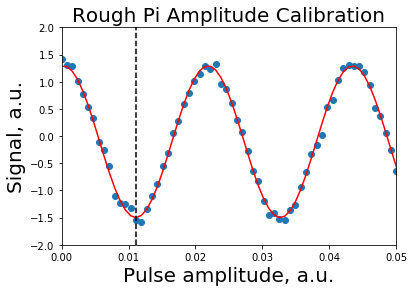

In [14]:
rabi_amp_data = get_amplitude(results_memory)

fit_func = lambda x,A,B,T,phi: (A*np.cos(2*np.pi*x/T+phi)+B)

#Fit the data
fitparams, conv = curve_fit(fit_func, drive_amps, rabi_amp_data, [1.0,0.0,0.02,0])

#get the pi amplitude
pi_amp = (np.pi-fitparams[3])*fitparams[2]/2/np.pi

plt.scatter(drive_amps, get_amplitude(results_memory))
plt.plot(drive_amps, fit_func(drive_amps, *fitparams), color='red')
plt.plot(np.ones(len(drive_amps))*pi_amp, np.linspace(-2,2,len(drive_amps)), color='black', linestyle='dashed')
plt.xlim(0, 0.05)
plt.ylim(-2, 2)
plt.xlabel('Pulse amplitude, a.u.', fontsize=20)
plt.ylabel('Signal, a.u.', fontsize=20)
plt.title('Rough Pi Amplitude Calibration', fontsize=20)

print('Pi Amplitude %f'%(pi_amp))

## _Measuring the IQ Distribution from the 0 and 1 States_

In this experiment, we observe a change of measured signals depending on a quantum state of qubit0. By setting `drive_amp` to `pi_amp` we previously obtained, we can apply $\pi$-pulse to the qubit0. To observe a distribution on the IQ plane, we set `meas_return` to `single` .

In [17]:
# Create schedule
schedules = []

# Pi-pulse
drive_amp = pi_amp

for ii in [0,1]:
    # drive pulse
    rabi_pulse = gaussian_pulse(duration=drive_samples, name='rabi_pulse_%d' % ii, amp=drive_amp, sigma=drive_sigma)
    
    # add commands to schedule
    schedule = pulse.Schedule(device, name='%d State Cal' % ii)
    
    if ii:
        schedule.insert(start_time=0,
                        command=rabi_pulse,
                        channel=device.q[0].drive)
    schedule.insert(start_time=drive_samples,
                    command=meas_pulse,
                    channel=device.q[0].measure)
    schedule.insert(start_time=drive_samples,
                    command=pulse.Acquire(duration=meas_samples, kernel=kernel),
                    channel=device.q[0].acquire)
    
    schedules.append(schedule)

In [18]:
opts = {
    'shots': 3000,
    'meas_level': 1,
    'meas_return': 'single',
    'memory_slot_size': 1
}

# Run on the real backend
job = execute_schedules(schedules, backend, **opts)

In [19]:
job.job_id()

'5c9dc4e4fbfd08005ce96249'

In [33]:
job.status()

<JobStatus.DONE: 'job has successfully run'>

In [34]:
iq_result = job.result(timeout=3600)

### Analyze the result

In [49]:
scale_factor=1e-10

results = iq_result.results

results_memory = []
for result in results:
    shots = result.data.memory
    tmp_memory = []
    for shot in shots:
       tmp_memory.append(np.asarray(list(map(lambda x: scale_factor*complex(*x), shot))))
    results_memory.append(np.asarray(tmp_memory)[:, 0])

Text(0, 0.5, 'Q (a.u.)')

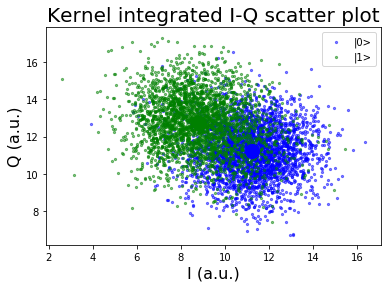

In [55]:
ground_data = results_memory[0]
excited_data = results_memory[1]

plt.scatter(np.real(ground_data), np.imag(ground_data), s=5, cmap='viridis',c='blue',alpha=0.5, label='|0>')
plt.scatter(np.real(excited_data), np.imag(excited_data), s=5, cmap='viridis',c='green',alpha=0.5, label='|1>')
ground_center = np.mean(ground_data)
excited_center = np.mean(excited_data)

plt.scatter(np.real(ground_center), np.imag(ground_center), c='blue', s=200, alpha=1.0)
plt.scatter(np.real(excited_center), np.imag(excited_center), c='green', s=200, alpha=1.0)

plt.title('Kernel integrated I-Q scatter plot', fontsize=20)
plt.legend(loc='upper right')
plt.xlabel('I (a.u.)', fontsize=16)
plt.ylabel('Q (a.u.)', fontsize=16)

## _Running Rabi Experiment with Different Frequencies_

Previous experiment is performed without specifying LO frequencies of qubit0. In this case, default drive frequencies from the backend configuration are automatically assigned. These values are calibrated to correspond with the qubit resonanse frequencies. In this experiment, we also change the LO frequencies of qubit0 and see what happens.

In [56]:
exps_amp = 64
exps_freq = 21
rabi_shots = 512
scale_factor=1e-10

# Rabi pulse
drive_amps = np.linspace(0, 0.1, exps_amp)
drive_samples = 128
drive_sigma = 32

# Measurement pulse
meas_amp = 0.025
meas_samples = 1200
meas_sigma = 4
meas_risefall = 25

# LO Frequency
drive_lo_freqs = np.linspace(-0.003, 0.003, exps_freq)

# Measurement pulse (common for all experiment)
meas_pulse = gaussian_square_pulse(duration=meas_samples, name='meas_pulse', amp=meas_amp,
                                   sigma=meas_sigma, risefall=meas_risefall)

# Measurement kernel (common for all experiment)
kernel = pulse.Kernel(name='boxcar', start_window=0, stop_window=1200)

# Backend options (common for all frequency sweep)
opts = {
    'shots': rabi_shots,
    'meas_level': 1,
    'meas_return': 'avg',
    'memory_slot_size': 8192
}

In [63]:
freq_d0_default = device.q[0].drive.lo_frequency

In [64]:
# Create schedule for each frequency
my_jobs = []
for jj, drive_lo_freq in enumerate(drive_lo_freqs):
    freq_d0 = freq_d0_default + drive_lo_freq
    schedules = []
    for ii, drive_amp in enumerate(drive_amps):
        # drive pulse
        rabi_pulse = gaussian_pulse(duration=drive_samples, name='rabi_pulse_%d' % ii, amp=drive_amp, sigma=drive_sigma)
        
        # add commands to schedule
        schedule = pulse.Schedule(device, name='Rabi Experiment at drive amp = %s' % drive_amp)

        schedule.insert(start_time=0,
                        command=rabi_pulse,
                        channel=device.q[0].drive)
        schedule.insert(start_time=drive_samples,
                        command=meas_pulse,
                        channel=device.q[0].measure)
        schedule.insert(start_time=drive_samples,
                        command=pulse.Acquire(duration=meas_samples, kernel=kernel),
                        channel=device.q[0].acquire)        
        
        # set LO frequency
        device.q[0].drive.set_lo_frequency(freq_d0)
        schedules.append(schedule)
    
    # Run on the real backend
    my_jobs.append(execute_schedules(schedules, backend, **opts))

** Using job monitor is not recommended because bluemix will shutout your frequent inquiries and which make the provider to cause an error.

In [28]:
for ii, job in enumerate(my_jobs):
    print('%s: %s' % (ii, job.status()))

0: JobStatus.DONE
1: JobStatus.DONE
2: JobStatus.DONE
3: JobStatus.DONE
4: JobStatus.DONE
5: JobStatus.DONE
6: JobStatus.DONE
7: JobStatus.DONE
8: JobStatus.DONE
9: JobStatus.DONE
10: JobStatus.DONE
11: JobStatus.DONE
12: JobStatus.DONE
13: JobStatus.DONE
14: JobStatus.DONE
15: JobStatus.DONE
16: JobStatus.DONE
17: JobStatus.DONE
18: JobStatus.DONE
19: JobStatus.DONE
20: JobStatus.DONE


### Analyze the result

As in the same manner as the previous experiment, we calculate signal amplitude for each experiment. The result provides a 2 dimensional array of signal amplitude with respect to drive amplitude and frequency. This is called qubit chevron pattern and we can see the change of Rabi rate that comes with the detuning of drive frequency.

In [29]:
results_memory = []

for job in my_jobs:
    print(job.job_id())
    rabi_result = job.result()

    # Add qubit0 results
    results = rabi_result.results

    tmp_memory = []
    for result in results:
        tmp_memory.append(np.asarray(list(map(lambda x: scale_factor*complex(*x), result.data.memory))))
    tmp_memory = np.asarray(tmp_memory)
    
    results_memory.append(tmp_memory[:, 0])

5c9329572ef857005e163904
5c9329577ee4cc006124eea7
5c93295c9800620055cf8c5a
5c932958c92a74005a0a7daf
5c932958feea1b005483f0d3
5c932959d15f3400576f6073
5c93295fd15f3400576f6075
5c93295a2ef857005e163906
5c93295ac92a74005a0a7db1
5c93295bea564b005d33f74d
5c93295c2ef857005e163908
5c9329629a0b650058724fb2
5c93295d7ee4cc006124eea9
5c93295f7ee4cc006124eeab
5c93295eff7e880059474732
5c93295eea564b005d33f74f
5c932963a40a140056d1fa56
5c93295f9800620055cf8c5c
5c93295fc6f9a800624cb6b5
5c9329609a0b650058724fb0
5c932960ae77080053357620


In [30]:
result_amps = np.asarray([get_amplitude(r) for r in results_memory]).T

Text(0, 0.5, 'Pulse amplitude, a.u.')

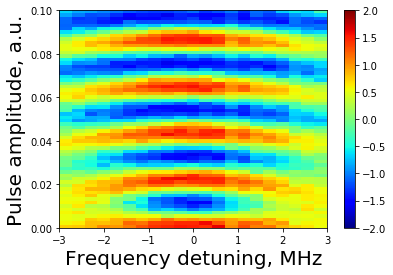

In [31]:
plt.imshow(result_amps,
           extent=[drive_lo_freqs.min() * 1e3, drive_lo_freqs.max() * 1e3, drive_amps.min(), drive_amps.max()],
           cmap='jet',
           vmin=-2, vmax=2,
           origin='lowest', aspect='auto')
plt.colorbar()
plt.xlabel('Frequency detuning, MHz', fontsize=20)
plt.ylabel('Pulse amplitude, a.u.', fontsize=20)